## Pixel-flipping GradCAM ECG D2long

In [1]:
from matplotlib import pyplot as plt

import tensorflow as tf
import sys
import h5py
import tensorflow as tf

import pandas as pd

import numpy as np
import matplotlib.cm as cm
import math

import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

In [2]:
def GradcamInterpreter(model, x_img, last_conv_layer_name):
    '''
    Aplica o método Kernel SHAP (Local Interpreter) em uma imagem aplicada no modelo classificador.
    
    Args.
        model: modelo treinado
        x_img: (1, im_height, im_width, 1) imagem a ser analisada
        last_conv_layer_name: str com o nome da camada convolucional que deveja analisar
            
    Returns.
        Plots do resultado do gradcam
        
    '''
    
    # Cria gradcam heatmap
    # ---------------------------------------
    def getGradcam(img_array, grad_model):
        '''
        Cria um grad-cam heatmap dado um modelo e uma camada contida no modelo


        Args:
          img_array: (None x img_width x img_height x 3) numpy array
          grad_model: class 'keras.engine.functional.Functional'
                      tf.keras.models.Model(inputs=[model.inputs],
                                            outputs=[model.get_layer(last_conv_layer_name).output, model.output])


        Returns 
          jet_heatmap: (img_width x img_height x 3) float32 numpy array that is the heatmap needed to superimpose in 
          the original image
        '''

        pred_index=None

        # Computamos o gradiente da melhor (top) classe predita para a imagem
        # de entrada com relação as ativações da última camada convolucional
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)

            if pred_index is None:
                pred_index = tf.argmax(preds[0])

            class_channel = preds[:, pred_index] # loss associated with the specific class index

        # Esse é o gradiente do neuronio de saída (top predicted or chosen)
        # com relação ao mapa de caracteristica de saída da ultima camada convolucional
        grads = tape.gradient(class_channel, last_conv_layer_output)
        # tape.gradient calculate the gradient of some target (often a loss) relative
        # to some source (often the model's variables)


        # Ou seja, até aqui nós rodamos a entrada no modelo, pegamos a saída da camada e a perda.
        # Depois, achamos o gradiente da saída da camada desejada com relação a perda do modelo.

        # Esse é um vetor onde cada entrada é a intensidade média do gradiente
        # sobre um canal de um mapa de característica específico
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Nós multiplicamos cada canal no vetor do mapa de características acima pelo
        # "quão importante aquele canal é" com relação a melhor classe predita, então
        # somamos todos os canais para obter o heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap) # Remove eixos com tamanho 1

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        #jet_colors = jet(np.arange(256))[:, :3]
        jet_colors = jet(np.arange(256))[:, :1]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
        
        plt.figure(figsize=(10,5))
        plt.imshow(jet_heatmap.astype(np.uint8))
        plt.title('Gradcam mask')
        plt.axis('off')

        return jet_heatmap
    

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Carrega entradas/saídas do modelo para pegar o gradiente da imagem de entrada até a camada desejada
    grad_model = tf.keras.models.Model(inputs=[model.inputs],
                                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Gerar heatmap do Grad-Cam
    jet_heatmap = getGradcam(x_img, grad_model)
    
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.imshow(x_img[0], cmap='gray')
    ax1.set_title("Original Image\n Class: FA")
    ax1.axis('off')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.imshow(x_img[0], cmap='gray')
    ax2.imshow(jet_heatmap.astype(np.uint8), alpha=0.5) # overlap
    ax2.set_title("Grad-Cam Image")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
    #fig.savefig('ecgD2_Gradcam_classFA.jpg')
    
    return jet_heatmap

## Image to be analyzed:  35
## Image prediction (NORMAL = 0 | FA = 1):  [[0.99960196]]


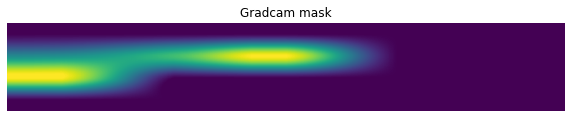

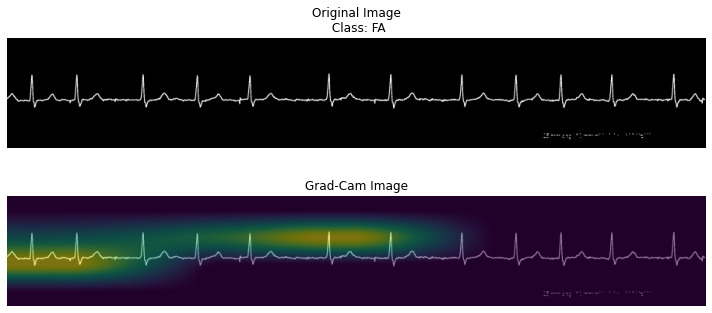

In [3]:
if __name__ == '__main__':
    
    
    # Carregando modelo de classificação
    model = tf.keras.models.load_model('modelD2long.h5', compile=False)
    #model.summary()

    # Abrindo dataset de exemplo
    h5 = h5py.File('ecgD2longImgs.h5', 'r') # Open file
    data = h5['2d'] # D2 images
    
    # LOAD IMAGE
    # Artigo: normal (3) | fa (35)
    #FA     = [8, 10, 17, 35, 37, 49, 60, 79]
    
    idx = 35

    x_img = data[idx] # FA
    x_img = np.expand_dims(x_img, axis = 0) # input shape nedded for the model

    print('## Image to be analyzed: ', idx)
    print('## Image prediction (NORMAL = 0 | FA = 1): ', model.predict(x_img/255))
    
    last_conv_layer_name = "conv2d_11"
    
    # Aplica interpretador
    jet_heatmap = GradcamInterpreter(model, x_img, last_conv_layer_name)

In [4]:
#def pixelflipping(img, coeff, jet_heatmap):
def pixelflipping(img, jet_heatmap):
    '''
    Gera um gráfico que demonstra se a remoção dos pixels destacados como mais importantes no método
    de interpretabilidade faz com que a performance do classificador caia significativamente. 
    Para isso, os pixels são removidos (set to zero) recursivamente, ordenados do mais 
    relevante ao menos relevante, e é realizada a predição para cada imagem gerada.
    Os pixels são removidos em porcentagem e.g. 10% removidos, 20%, 30%, etc....
    
    Args.
        img: (height x width x [1 or 3])
        coeff: (num_pixels, ) coefficients vector
        
    Returns.
        Curvas individuais para a imagem analisada
        predictions: (11, ) prediction vector 
    
    '''
    
    print('#### RUNNING PIXELFLIPPING...')
    
    coeff = jet_heatmap
    coeff = coeff.flatten()
    
    
    # -------------------------------------------------------------------------------------
    def remove_segment(img, item, jet):
        '''
        Gera uma imagem com segmento removido (set to zero)

        Args.
            img: (height x width x [1 or 3])


        Returns.
            perturbed_image: (height x width x 3) 


        '''
        mask = np.ones(img.shape)
        perturbed_image = copy.deepcopy(img)
        
        # Remove element from heatmap
        mask[jet == item] = 0
        perturbed_image = perturbed_image * mask

        return perturbed_image
    # -------------------------------------------------------------------------------------
    
    # -------------------------------------------------------------------------------------
    def plot_pred(predictions):
        '''
        Pixel-flipping curve for an individual image
        
        Args.
            predictions: (num_superpixels, ) prediction vector
            
            
        '''
        x = [0,10,20,30,40,50,60,70,80,90,100]
        fig = plt.figure(figsize=(15,10))
        plt.plot(x, predictions, linewidth=2.0, c='r')
        plt.title("Pixel-flipping curve")
        plt.xlabel("Porcentage of pixels flipped")
        plt.ylabel("Output score")
        plt.ylim(0, 1)
        plt.xlim(0, 100)
        plt.grid()
    # -------------------------------------------------------------------------------------
    
    # sort coefficients
    top_coeff_idx = coeff.argsort()[::-1]
    top_coeff = coeff[top_coeff_idx]
    
    # Unique coefficients
    #unique_coeff = np.unique(coeff)
    
    predictions = []
    
    # Prediction with all segments
    n_preds = model.predict(img/255)
    print('Predicted: ', n_preds)
    predictions.append(n_preds)

    x = copy.deepcopy(img)
    x = x[0,...]

    # Selecionando % de coeff para flipar
    for z in range(10,110,10):
        print('Porcentagem de pixels removidos: ', z)
        pto = math.ceil( len(top_coeff) * (z/100) )
        remove = top_coeff[0:pto]
        
        for i in range(len(remove)):
            item = remove[i]
            perturbed_img = remove_segment(x, item, jet_heatmap)
            x = perturbed_img

        plt.figure()
        plt.imshow(x)
        n_preds = model.predict(x[np.newaxis,...]/255)
        print('Predicted: ', n_preds)
        predictions.append(n_preds)

    predictions = np.array(predictions)
    predictions = predictions[:, 0, 0]
    #plot_pred(predictions[:, 0, class])   # For multiclass
    plot_pred(predictions)
    
    print('#### DONE.')

    return predictions

#### RUNNING PIXELFLIPPING...
Predicted:  [[0.99960196]]
Porcentagem de pixels removidos:  10
Predicted:  [[0.99948585]]
Porcentagem de pixels removidos:  20
Predicted:  [[0.996704]]
Porcentagem de pixels removidos:  30
Predicted:  [[0.9810132]]
Porcentagem de pixels removidos:  40
Predicted:  [[0.7757586]]
Porcentagem de pixels removidos:  50
Predicted:  [[2.3097017e-07]]
Porcentagem de pixels removidos:  60
Predicted:  [[2.3097017e-07]]
Porcentagem de pixels removidos:  70
Predicted:  [[2.3097017e-07]]
Porcentagem de pixels removidos:  80
Predicted:  [[2.3097017e-07]]
Porcentagem de pixels removidos:  90
Predicted:  [[2.3097017e-07]]
Porcentagem de pixels removidos:  100
Predicted:  [[2.3097017e-07]]
#### DONE.


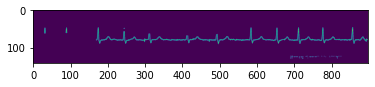

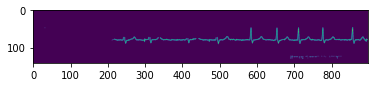

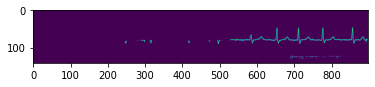

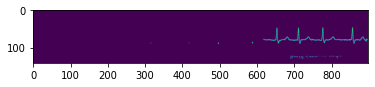

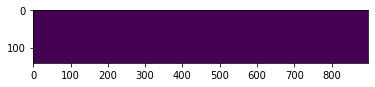

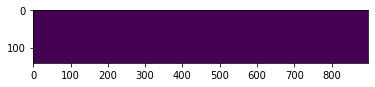

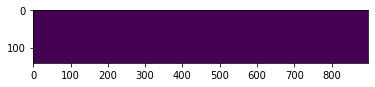

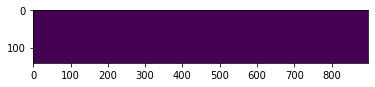

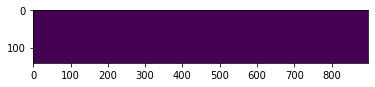

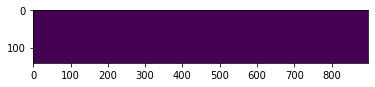

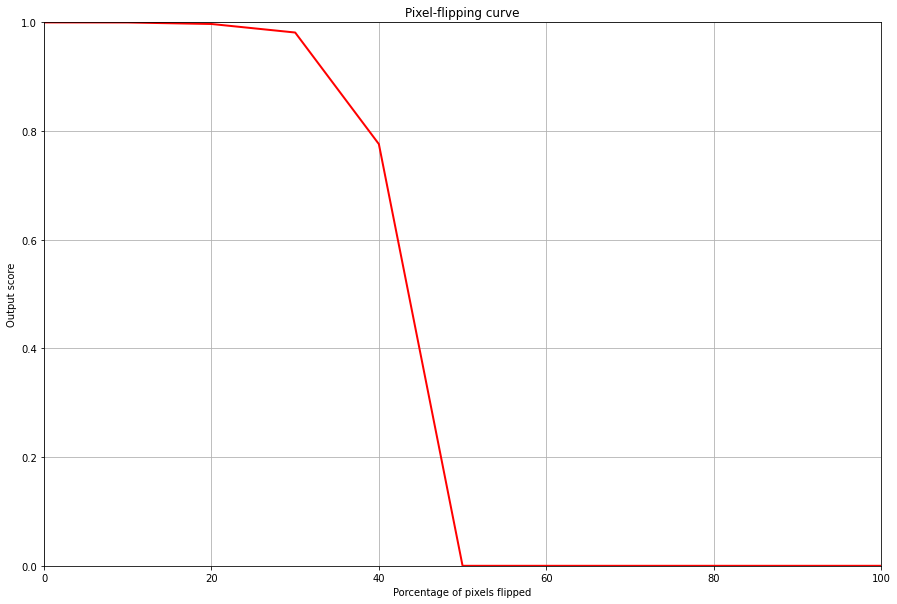

In [5]:
#coeff = jet_heatmap
#coeff = coeff.flatten()

# Run Pixel-flipping
#predictions = pixelflipping(x_img, coeff, jet_heatmap)
predictions = pixelflipping(x_img, jet_heatmap)